# Showing the sugar content of black coffee

## 당뇨 환자를 위한 블랙커피 당 성분 표시 AI 솔루션

현재 대한민국의 성인 당뇨 환자는 600만명이 넘으며 그 중 65세 이상의 노인 환자는 39.2%로 노인 당뇨병 관리의 중요성이 점차 커지고 있다. 
그럼에도 불구하고 당뇨병 관리는 낙제점 수준이다. 현재 당뇨병이 관리되고 있는 환자는 10명중 1명에 그친다. 

당뇨병 환자라면 식단 관리가 필수다. 혈당 수치를 정상 범위로 유지해야 하기 때문이다.
병원 내 편의점에서 아르바이트를 할 때,  
당뇨로 입원한 시력이 좋지 않은 어르신 분이 블랙커피의 성분분석표가 보기 힘들어 
당 함량을 확인하지 못하고 당이 든 커피를 마셔서 혈당이 올라 힘드셨다는 이야기를 들었고 당뇨병 환자의 대다수가 노인인 점에서 블랙커피 당 성분 표시 AI 모델을 만들면 그들에게 도움을 줄 수 있을 것 이라 생각했다. 

여러가지 분류 AI 모델을 사용하여 그 중 제일 성능이 좋은 모델인 MobileNetV2 선택하여 예측해보았다.

## 라이브러리 불러오기

In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

## Dataset 읽기

In [2]:
coffee_dir = 'C:/Users/21/Desktop/coffee data/train/'

img_path_list = []
possible_img_extension = ['.jpg', '.jpeg', '.JPG', '.bmp', '.png'] # 이미지 확장자들
 
for (root, dirs, files) in os.walk(coffee_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_img_extension:
                img_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                img_path = img_path.replace('\\', '/') # \는 \\로 나타내야함         
                img_path_list.append(img_path)

filepaths = img_path_list

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)


,Filepath,Label
0,C:/Users/21/Desktop/coffee data/train/3/89.jpg,3
1,C:/Users/21/Desktop/coffee data/train/0/104.jpg,0
2,C:/Users/21/Desktop/coffee data/train/1/10.jpg,1
3,C:/Users/21/Desktop/coffee data/train/3/292_21...,3
4,C:/Users/21/Desktop/coffee data/train/1/196.jpg,1


### 이미지 데이터 전처리

In [3]:
size = 224
mean = (0.485, 0.456, 0.456)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [4]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1709

Number of different labels: 7

Labels: ['3' '0' '1' '4' '2' '5' '6']


### 이미지 데이터 확인

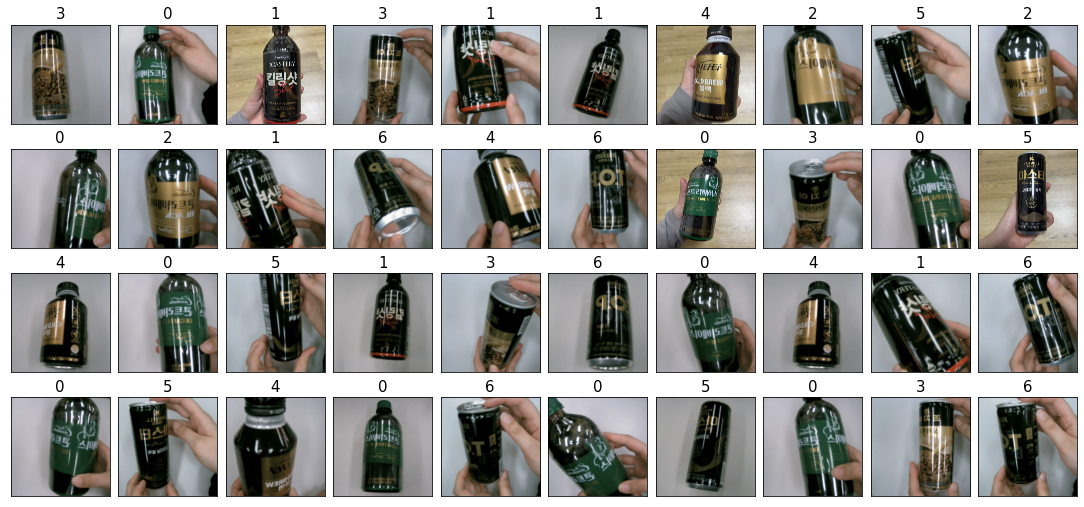

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

### Label Category 분포 확인

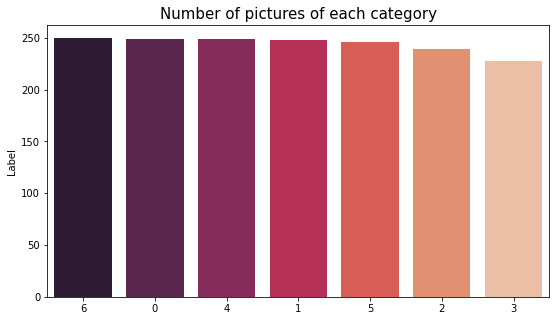

In [6]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

### 이미지 데이터 Train, Test 데이터로 분류

In [7]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((1538, 2), (171, 2))

## 베이스 라인 모델
### 모델 전처리

In [8]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory( 'C:/Users/21/Desktop/coffee data/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory( 'C:/Users/21/Desktop/coffee data/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1371 images belonging to 7 classes.
Found 338 images belonging to 7 classes.


### 딥러닝 CNN모델로 베이스라인 모델링

In [9]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=7, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [10]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)


Epoch 1/10
43/43 [==============================] - 36s 827ms/step - loss: 1.8525 - accuracy: 0.4748 - val_loss: 1.6033 - val_accuracy: 0.4941
Epoch 2/10
43/43 [==============================] - 24s 556ms/step - loss: 0.2297 - accuracy: 0.9373 - val_loss: 1.2644 - val_accuracy: 0.7101
Epoch 3/10
43/43 [==============================] - 24s 564ms/step - loss: 0.0439 - accuracy: 0.9876 - val_loss: 1.7991 - val_accuracy: 0.6657
Epoch 4/10
43/43 [==============================] - 24s 549ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.5304 - val_accuracy: 0.7130
Epoch 5/10
43/43 [==============================] - 24s 557ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.6357 - val_accuracy: 0.7367
Epoch 6/10
43/43 [==============================] - 26s 602ms/step - loss: 9.4809e-04 - accuracy: 1.0000 - val_loss: 1.8103 - val_accuracy: 0.6982
Epoch 7/10
43/43 [==============================] - 24s 559ms/step - loss: 6.0374e-04 - accuracy: 1.0000 - val_loss: 1.8208 - val_accuracy

### 모델 성능 높이기

### 데이터 증강(Data Augmentation)으로 이미지 로드

In [11]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

### 전이학습을 사용해서 모델 성능 높이기

In [12]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    # 라벨 개수가 7개이기 때문에 Dencs도 7로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1385 validated image filenames belonging to 7 classes.
Found 153 validated image filenames belonging to 7 classes.
Found 171 validated image filenames belonging to 7 classes.


DenseNet121          trained in 96.09 sec
MobileNetV2          trained in 36.94 sec
DenseNet201          trained in 154.59 sec
EfficientNetB0       trained in 61.88 sec
EfficientNetB1       trained in 85.49 sec
InceptionV3          trained in 44.38 sec
MobileNetV3Large     trained in 39.38 sec
ResNet152V2          trained in 170.58 sec
ResNet50             trained in 88.49 sec
ResNet50V2           trained in 70.24 sec
VGG19                trained in 150.52 sec
VGG16                trained in 124.86 sec
Xception             trained in 75.27 sec


### Test 데이터로 성능 확인

In [13]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
    #Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

6/6 [==============================] - 11s 2s/step
**DenseNet121 has a 94.74% accuracy on the test set**
6/6 [==============================] - 5s 623ms/step
**MobileNetV2 has a 100.00% accuracy on the test set**
6/6 [==============================] - 18s 3s/step
**DenseNet201 has a 98.83% accuracy on the test set**
6/6 [==============================] - 7s 931ms/step
**EfficientNetB0 has a 16.96% accuracy on the test set**
6/6 [==============================] - 10s 1s/step
**EfficientNetB1 has a 14.62% accuracy on the test set**
6/6 [==============================] - 6s 665ms/step
**InceptionV3 has a 91.23% accuracy on the test set**
6/6 [==============================] - 5s 616ms/step
**MobileNetV3Large has a 36.26% accuracy on the test set**
6/6 [==============================] - 21s 3s/step
**ResNet152V2 has a 98.83% accuracy on the test set**
6/6 [==============================] - 10s 1s/step
**ResNet50 has a 28.65% accuracy on the test set**
6/6 [==============================] -

,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.9869,1.0000,36.94
1,DenseNet201,0.9935,0.9883,154.59
2,ResNet152V2,0.9935,0.9883,170.58
3,ResNet50V2,0.9935,0.9766,70.24
4,Xception,0.9869,0.9766,75.27
5,DenseNet121,0.9739,0.9474,96.09
6,InceptionV3,0.9608,0.9123,44.38
7,VGG19,0.7778,0.7719,150.52
8,VGG16,0.6797,0.6608,124.86
9,MobileNetV3Large,0.3660,0.3626,39.38


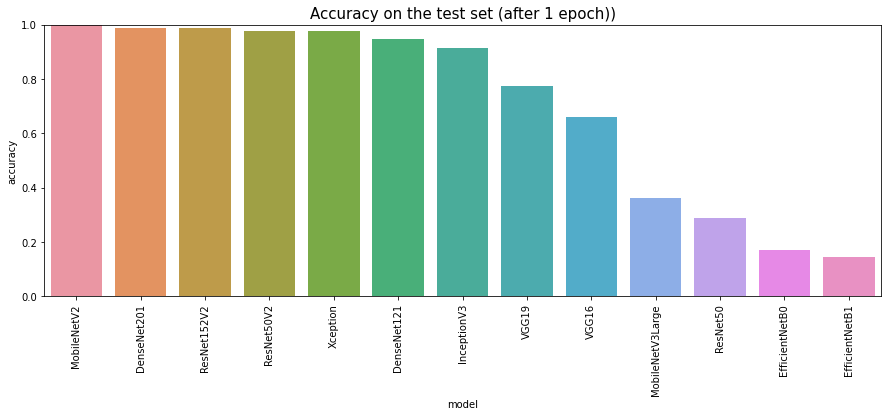

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

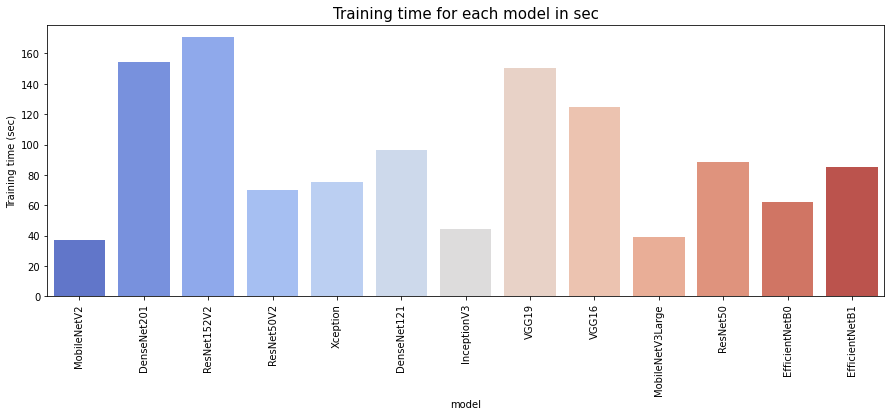

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results, palette='coolwarm')
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

### 모델 성능 확인_MobileNetV2,InceptionV3

좋은 효율을 내는 모델 성능확인 1 (MobileNetV2)

In [16]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1385 validated image filenames belonging to 7 classes.
Found 153 validated image filenames belonging to 7 classes.
Found 171 validated image filenames belonging to 7 classes.
Epoch 1/7
44/44 [==============================] - 37s 778ms/step - loss: 0.4785 - accuracy: 0.8722 - val_loss: 0.0702 - val_accuracy: 0.9935
Epoch 2/7
44/44 [==============================] - 34s 777ms/step - loss: 0.0230 - accuracy: 0.9978 - val_loss: 0.0259 - val_accuracy: 0.9935
Epoch 3/7
44/44 [==============================] - 33s 749ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 4/7
44/44 [==============================] - 32s 717ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 5/7
44/44 [==============================] - 32s 723ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/7
44/44 [==============================] - 34s 761ms/step - loss: 0.0011 - accuracy: 1.0000 - val_los

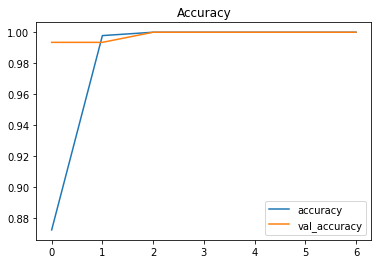

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

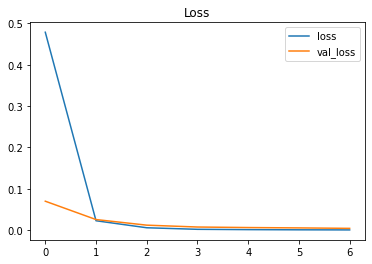

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

좋은 효율을 내는 모델 성능확인 2 (InceptionV3)

In [19]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model2 = get_model(tf.keras.applications.InceptionV3)
history = model2.fit(train_images,validation_data=val_images,epochs=7)

Found 1385 validated image filenames belonging to 7 classes.
Found 153 validated image filenames belonging to 7 classes.
Found 171 validated image filenames belonging to 7 classes.
Epoch 1/7
44/44 [==============================] - 47s 966ms/step - loss: 0.7121 - accuracy: 0.7646 - val_loss: 0.1761 - val_accuracy: 0.9477
Epoch 2/7
44/44 [==============================] - 39s 880ms/step - loss: 0.0767 - accuracy: 0.9870 - val_loss: 0.0719 - val_accuracy: 0.9739
Epoch 3/7
44/44 [==============================] - 38s 863ms/step - loss: 0.0384 - accuracy: 0.9957 - val_loss: 0.0349 - val_accuracy: 0.9935
Epoch 4/7
44/44 [==============================] - 39s 888ms/step - loss: 0.0276 - accuracy: 0.9949 - val_loss: 0.0628 - val_accuracy: 0.9673
Epoch 5/7
44/44 [==============================] - 39s 891ms/step - loss: 0.0116 - accuracy: 0.9993 - val_loss: 0.0222 - val_accuracy: 0.9935
Epoch 6/7
44/44 [==============================] - 40s 904ms/step - loss: 0.0053 - accuracy: 0.9993 - val_los

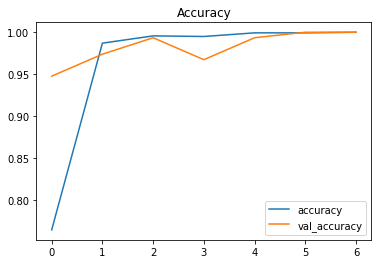

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

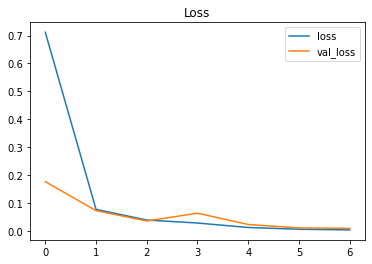

In [21]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

6/6 [==============================] - 5s 603ms/step
Accuracy on the test set: 100.00%


### 성능 100% 모델의 정밀도와 재현율

In [23]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        29

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



### Confusion Matrix 시각화
Confusion 매트릭스도 히트맵을 통해서 나타내 보았는데 본인외에 전부 어두운색으로 나타낸다.

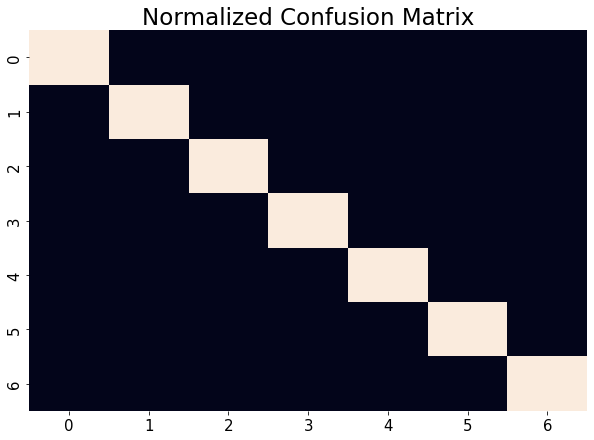

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 실전 : 모델 예측

번호를 입력하세요 : 12
1/1 [==============================] - 1s 683ms/step


## 예측률 : 99.99%

### Class prediction = 4

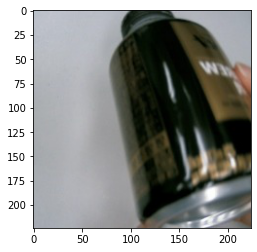

In [25]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'0': 0,
                    '1': 1,
                    '2': 2,
                    '3': 3,
                    '4': 4,
                    '5': 5,
                    '6': 6,
                    }
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [26]:
coffee_dir = 'C:/Users/21/Desktop/coffee data/download'

img_path_list = []
possible_img_extension = ['.jpg', '.jpeg', '.JPG', '.bmp', '.png'] # 이미지 확장자들
 
for (root, dirs, files) in os.walk(coffee_dir):
    if len(files) > 0:
        for file_name in files:
            if os.path.splitext(file_name)[1] in possible_img_extension:
                img_path = root + '/' + file_name
                
                # 경로에서 \를 모두 /로 바꿔줘야함
                img_path = img_path.replace('\\', '/') # \는 \\로 나타내야함         
                img_path_list.append(img_path)

filepaths = img_path_list

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    
    # 경로와 라벨 concatenate
    df = pd.DataFrame(filepath)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

download_data = proc_img(filepaths)
download_data.head(5)


,Filepath
0,C:/Users/21/Desktop/coffee data/download/data4...
1,C:/Users/21/Desktop/coffee data/download/32.jpg
2,C:/Users/21/Desktop/coffee data/download/30.jpg
3,C:/Users/21/Desktop/coffee data/download/d2.jpg
4,C:/Users/21/Desktop/coffee data/download/106.jpg


In [27]:
size = 224
mean = (0.485, 0.456, 0.456)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [28]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )


    test_images = test_generator.flow_from_dataframe(
        dataframe=download_data,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return test_images

번호를 입력하세요 : 1
1/1 [==============================] - 0s 29ms/step


## 예측률 : 72.17%

### Class prediction = 5

sugars: 0g


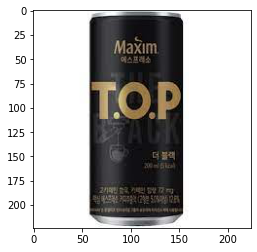

In [38]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'0': 0,
                    '1': 1,
                    '2': 2,
                    '3': 3,
                    '4': 4,
                    '5': 5,
                    '6': 6,
                    }
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(download_data.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df
                                .iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")

    result = int(x)
    if result == 0:
        print("sugars: 0g")
    elif result ==1:
        print("sugars: 2g")
    elif result == 2:
        print("sugars: 4g")
    elif result ==3:
        print("sugars: 18g")
    elif result ==4:
        print("sugars: 1.5g")
    elif result ==5:
        print("sugars: 0g")
    else:
        print("sugars: 0g")
    
    break
    

# 후기

   직접 촬영한 사진이 아닌 인터넷에서 다운받은 사진으로 분류해보았을 때 패키징이 비슷한 6번을 5번으로 예측하는 경향을 보였다. 
   훈련시키는 데이터를 좀 더 다양한 장소에서 찍은 사진으로 더 많은 데이터로 훈련을 하면 5,6번 또한 분류를 잘 할 것 같다..! 
   캠으로 비추었을 때 위에 바로 뜨는 걸 구현하고 싶었으나,,, 능력부족으로....... 예측하고 당 성분 띄우는 정도로만 코드를 짜서 조금 아쉽다.